# Table with for Ketura Science paper

The objective of this script is to automatically generate the radiative fluxes table of this paper, and export it to LaTeX, with the proper t-tests.

In [8]:
import pandas as pd
import openpyxl
import numpy as np
import glob
from plotnine import *
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy import signal
from plotnine import ggplot, geom_point, aes, stat_smooth, facet_wrap
from scipy import stats
import os
from plotnine.data import mtcars
from functools import reduce
from itertools import product, combinations

### Input and output paths

In [9]:
#project_path = 'D:/Users/Rafaels/Dropbox/Doutorado/Working/Ketura/'   # Weizmann desktop
project_path = 'C:/Users/rafas/Dropbox/Doutorado/Working/Ketura/'     # notebook
input_path   = project_path + '01_data/'
output_path  = project_path + '02_output/'
graphs_path  = project_path + '03_graphs/'

# Functions

In [30]:
# Loads all data in the folder
def load_all_data(path):
    file_list = sorted(glob.glob(path + '*corr.csv', recursive=True))

    data_list = []
    for filename in file_list:
        fn_without_path = filename.replace(path[:-1], "")[1:]
        print("Loading", fn_without_path)
        
        temp = pd.read_csv(filename)
        # attribute Season and Ecosystem
        temp['Ecosystem'] = fn_without_path.split(' ')[2]
        temp['Year'] = fn_without_path.split(' ')[5]
        temp['Month'] = fn_without_path.split(' ')[4]
        temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)
        
        temp.loc[temp['Month'] == 'July', 'Season'] = 'Summer'
        temp.loc[temp['Month'] == 'October', 'Season'] = 'Autumn'
        temp.loc[temp['Month'] == 'March', 'Season'] = 'Spring'
        temp.loc[temp['Ecosystem'] == 'Solar', 'Ecosystem'] = 'PV field'
        temp.loc[temp['Ecosystem'] == 'Desert', 'Ecosystem'] = 'Desert background'
        temp.loc[temp['Ecosystem'] == 'Yatir', 'Ecosystem'] = 'Yatir desert'
        
        data_list.append(temp)
        
    # Combine all the read data
    df = pd.concat(data_list, axis=0, ignore_index=True)
    
    # Rename
    df.rename(columns={'H_mdsgf_SH': 'H'}, inplace=True)
    df.rename(columns={'LE_mdsgf_SLE': 'LE'}, inplace=True)
    df.rename(columns={'LW_IN_average_corr': 'Lin'}, inplace=True)
    df.rename(columns={'LW_OUT_average_corr': 'Lout'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'SWin'}, inplace=True)
    df.rename(columns={'SW_OUT_average': 'SWout'}, inplace=True)
    df.rename(columns={'PA_average': 'Pa'}, inplace=True)

    
    # Convert columns to float
    df['H']  = pd.to_numeric(df['H'], downcast="float")
    df['LE'] = pd.to_numeric(df['LE'], downcast="float")
    df['Lin']  = pd.to_numeric(df['Lin'], downcast="float")
    df['Lout'] = pd.to_numeric(df['Lout'], downcast="float")
    df['SWin']  = pd.to_numeric(df['SWin'], downcast="float")
    df['SWout'] = pd.to_numeric(df['SWout'], downcast="float")
    df['H2O'] = pd.to_numeric(df['H2O'], downcast="float")
    df['Pa'] = pd.to_numeric(df['Pa'], downcast="float")
    df['Temperaturek']  = pd.to_numeric(df['TA_average'], downcast="float")
    
    df['Ta']  = df['Temperaturek'] - 273.15

    # Calculating Rn
    df['Rn'] = df['SWin'] - df['SWout'] + df['Lin'] - df['Lout']
    df['Rn_from_drone'] = df['SWin'] - df['SWout'] + df['Lin'] - df['Lout']
    
    # Calculating temperature from lout
    # Constants
    sigma = 5.670374419*10**(-8) # Stefan-Boltzmann constant
    
    df['Ts'] = ((df['Lout']/(0.89*sigma))**0.25) - 273.15
    
    # Keep only relevant columns
    df = df[['DateTime','Season','Ecosystem','Lin','Lout']]
    
    display (df)
    return(df)


def rename_and_convert_drone(df):
    
    # Rename
    df.rename(columns={'H_mdsgf_SH': 'H'}, inplace=True)
    df.rename(columns={'LE_mdsgf_SLE': 'LE'}, inplace=True)
    df.rename(columns={'LW_IN_average_corr': 'Lin_from_drone'}, inplace=True)
    df.rename(columns={'LWout_corr': 'Lout_from_drone'}, inplace=True)
    df.rename(columns={'SW_IN_average': 'SWin'}, inplace=True)

       
    # Convert columns to float
    df['H']  = pd.to_numeric(df['H'], downcast="float")
    df['LE'] = pd.to_numeric(df['LE'], downcast="float")
    df['Lin']  = pd.to_numeric(df['Lin_from_drone'], downcast="float")
    df['Lout'] = pd.to_numeric(df['Lout_from_drone'], downcast="float")
    df['SWin']  = pd.to_numeric(df['SWin'], downcast="float")

    # Estimating SWout based on the fixed albedo value from March 2018 (0.23)
    
    df['SWout'] = df['SWin']*0.23

    # Calculating Rn
    df['Rn_from_drone'] = df['SWin'] - df['SWout'] + df['Lin_from_drone'] - df['Lout_from_drone']
    
    # Calculating temperature from lout
    # Constants
#     sigma = 5.670374419*10**(-8) # Stefan-Boltzmann constant
    
#     df['Ts_from_drone'] = ((df['Lout_from_drone']/(0.89*sigma))**0.25) - 273.15
    
    df['Ecosystem'] = 'PV field'
    df['Year'] = df['DateTime'].dt.year
    df['Month'] = df['DateTime'].dt.month

    
    # Keep only relevant columns
    df = df[['DateTime','Season','Year','Ecosystem','H','LE','Rn_from_drone']]
    # define mid-day
    #df = df.loc[(df['DateTime'].dt.hour >= 11) & (df['DateTime'].dt.hour < 13)]  
         
    return(df)

def averaging(temp):
    
    # define mid-day
    temp = temp.loc[(temp['DateTime'].dt.hour >= 10) & (temp['DateTime'].dt.hour < 15)].copy() 

    # Make mean and std dev
    df_means = temp.groupby(['Season','Ecosystem']).mean().reset_index()
    df_sds   = temp.groupby(['Season','Ecosystem']).std().reset_index()
    # rename columns
    df_means.rename(columns={'H': 'H_mean'}, inplace=True)
    df_means.rename(columns={'LE': 'LE_mean'}, inplace=True)
    df_means.rename(columns={'Rn': 'Rn_mean'}, inplace=True)
    df_means.rename(columns={'Ta': 'Ta_mean'}, inplace=True)
    df_means.rename(columns={'Ts': 'Ts_mean'}, inplace=True)
    df_means.rename(columns={'D_T': 'D_T_mean'}, inplace=True)
    df_means.rename(columns={'Pa': 'Pa_mean'}, inplace=True)
    df_means.rename(columns={'H2O': 'H2O_mean'}, inplace=True)
    df_means.rename(columns={'rH': 'rH_mean'}, inplace=True)

    df_sds.rename(columns={'H': 'H_sd'}, inplace=True)
    df_sds.rename(columns={'LE': 'LE_sd'}, inplace=True)
    df_sds.rename(columns={'Rn': 'Rn_sd'}, inplace=True)
    df_sds.rename(columns={'Ta': 'Ta_sd'}, inplace=True)
    df_sds.rename(columns={'Ts': 'Ts_sd'}, inplace=True)
    df_sds.rename(columns={'D_T': 'D_T_sd'}, inplace=True)
    df_sds.rename(columns={'Pa': 'Pa_sd'}, inplace=True)
    df_sds.rename(columns={'H2O': 'H2O_sd'}, inplace=True)
    df_sds.rename(columns={'rH': 'rH_sd'}, inplace=True)
    
    merged = df_means.merge(df_sds, on=['Season','Ecosystem'])
    
    # Keep only relevant columns
    merged = merged[['Season','Ecosystem','H_mean','LE_mean','Rn_mean','Ta_mean','Ts_mean','D_T_mean','Pa_mean','H2O_mean','rH_mean',\
                     'H_sd','LE_sd','Rn_sd','Ta_sd','Ts_sd','D_T_sd','Pa_sd','H2O_sd','rH_sd']]
    
    return(merged)

def load_tower(fn, silent=False):
    if (not silent): print('EC Tower')
    temp = pd.read_csv(fn, index_col=None)
    temp.rename({'date_mid_hour': 'DateTime'}, axis=1, inplace=True)
    temp['DateTime'] = pd.to_datetime(temp['DateTime'], format='%d%b%y:%H:%M', utc=True)
    # Remove obsolete columns
    temp.drop(['year','date','DOY','month','weekNo','mid_hour','mmyy','Bat_V','Hum_AC'], axis=1, inplace=True)
    if (not silent): print("    ", '100.0 %\t', fn.split('/')[-1])
    return(temp)


# def diurnal(temp,Ecosystem,Season):
    
#     temp = temp.loc[(temp['Ecosystem'] == Ecosystem) & (temp['Season'] == Season)].copy()
    
#     # creating 'Time' column
#     temp['Time'] = temp['DateTime'].dt.strftime('%H:%M')
    
#     # Keep only relevant columns
#     temp = temp[['Time','Ecosystem','Lout']]
    
#     # Make mean and std dev
#     df_means = temp.groupby(['Ecosystem','Time']).mean().reset_index()
#     df_sds   = temp.groupby(['Ecosystem','Time']).std().reset_index()
#     # rename columns
#     df_means.rename(columns={'Lout': 'Lout_mean'}, inplace=True)
#     df_means.rename(columns={'Lin': 'Lin_mean'}, inplace=True)
#     df_means.rename(columns={'Sout': 'Sout_mean'}, inplace=True)
#     df_means.rename(columns={'Sin': 'Sin_mean'}, inplace=True)
#     df_means.rename(columns={'PARout': 'PARout_mean'}, inplace=True)
#     df_means.rename(columns={'PARin': 'PARin_mean'}, inplace=True)
    
#     df_sds.rename(columns={'Lout': 'Lout_sd'}, inplace=True)
#     df_sds.rename(columns={'Lin': 'Lin_sd'}, inplace=True)
#     df_sds.rename(columns={'Sout': 'Sout_sd'}, inplace=True)
#     df_sds.rename(columns={'Sin': 'Sin_sd'}, inplace=True)
#     df_sds.rename(columns={'PARout': 'PARout_sd'}, inplace=True)
#     df_sds.rename(columns={'PARin': 'PARin_sd'}, inplace=True)
    
#     merged = df_means.merge(df_sds, on=['Ecosystem','Time'])
    
#     return(merged)

def pvalue_text(p):
    if(p <= 0.001): p_text = '<.001'
    if(p > 0.001): p_text = '<.01'
    if(p > 0.01): p_text = '<.05'
    if(p > 0.05): p_text = p.round(2).astype(str)
    return(p_text)

def ttest_all(temp, category, list_of_test_cols, group_col):
    # Prepare name of categories to test against each other
    group1 = temp[group_col].unique()[0]
    group2 = temp[group_col].unique()[1]
    print('Testing', group1, '&', group2)
    
    # Prepare df for results
    out_df = pd.DataFrame(list(product(list_of_test_cols, temp[category].dropna().unique())), columns=['Parameter', category])
    out_df['p'] = np.nan
    
    # Do t-tests for all combinations
    for col in list_of_test_cols:
        #print('----')
        #print(col)
        for cat in temp[category].dropna().unique():
            #print(cat)
            a = temp.loc[(temp[group_col] == group1) & (temp[category] == cat),col]
            b = temp.loc[(temp[group_col] == group2) & (temp[category] == cat),col]
            t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            print(col, cat, ':', pvalue_text(t[1]))
            # Add data to resulting df
            out_df.loc[(out_df[category] == cat) & (out_df['Parameter'] == col), 'p'] = pvalue_text(t[1])
    
    return(out_df)

def ttest_all2(temp, categories_to_test, list_data_cols, test_type='independent'):
    # Prepare list of lists
    list_of_lists = []
    for cat_i, cat in enumerate(categories_to_test):
        sub_categories = list(temp[cat].unique())
        list_of_lists.append(sub_categories)
    print('All categories:', list_of_lists)
    
    # Count number of categories
    cat_count = len(categories_to_test)
    list_of_dfs = []
    
    # Go through the list of all data columns
    for data_col in list_data_cols:
        print("Testing data column: ", data_col)
        
        # Prepare empty list of lists to fill
        out_list = []
        # List all combinations, and go through
        for i in list(combinations( list(product(*list_of_lists)) , 2)):
            # If no x-1 elements (for 3 categories, that's 2) overlaps, skip
            # This makes sure not to test combinations where everything is different
            # (e.g. Autumn Pines Hamsin vs Spring Maquis Normal)
            if(sum([j in i[0] for j in i[1]]) < (cat_count-1)):
                continue
            #print(i)  # DEBUG
            # Prepare row to append data
            row_list = []
            a_conditions = []
            b_conditions = []
            # Check which elements are the same in each pair
            for j in range(cat_count):
                if(i[0][j] == i[1][j]):
                    #print('Identical columns:', i[0][j]) # DEBUG
                    row_list.append(i[0][j])
                else:
                    #print('Column to test:', categories_to_test[j]) # DEBUG
                    row_list.append('')
                # Create list of conditions
                a_conditions.append(temp[categories_to_test[j]] == i[0][j])
                b_conditions.append(temp[categories_to_test[j]] == i[1][j])
            # Create the text of which 2 variables are being tested against each other
            test_str = list(set(i[0]) - set(i[1]))[0] + ' vs. ' + list(set(i[1]) - set(i[0]))[0]
            row_list.append(test_str)
            # Prepare t-test
            a = temp.loc[reduce(np.logical_and, a_conditions), data_col]
            b = temp.loc[reduce(np.logical_and, b_conditions), data_col]
            if(test_type == 'independent'):
                t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
            else:
                t = stats.ttest_rel(a, b, nan_policy='omit') # Paired t-test
            #row_list.append(t[1]) # Full P value
            row_list.append(pvalue_text(t[1])) # P value as text
            # Add p values to final output
            out_list.append(row_list)
    
        # Column names
        colnames = categories_to_test + ['Test','P_'+data_col]
        out_df = pd.DataFrame(out_list, columns=colnames)
        list_of_dfs.append(out_df)
    
    # Finally merge all
    final_df = reduce(lambda df1,df2: pd.merge(df1,df2, on=categories_to_test + ['Test']), list_of_dfs)
    print('Done...')
    
    return(final_df)

In [31]:
# Calculate saturation vapour pressure from pressure and temperature
# - 2 methods are available. Jones uses air pressure, Campbell & Norman do not
def calculate_es(T_C, P_Pa):
    # Jones p.348 (appendix 4)
    #es = (1.00072+(10**(-7)*P_Pa*(0.032+5.9*10**(-6)*T_C**2))) * (611.21*np.exp( (18.678-(T_C/234.5))*T_C/(257.14+T_C) ))

    # Eddypro manual: https://www.licor.com/env/support/EddyPro/topics/calculate-micromet-variables.html
    # Campbell & Norman (1998)
    T_K = T_C + 273.15
    es = T_K**(-8.2) * np.exp(77.345 + 0.0057*T_K - 7235 * T_K**(-1))
    return(es)

# Converts water concentration [mmol.mol] to RH [%]
def convert_mmol_RH(T_C, h2o_mmol_mol, P_Pa):
    
    T_K = T_C + 273.15
    #es = calculate_es(T_C, P_Pa)
    #RH <- 0.263*P_Pa*((h2o_mmol_mol*18.02/28.97)/1000)*np.exp(17.67*(T_C)/(T_K-29.65))**(-1)
    #RH = 100 if (RH > 100) else RH
    #RH = np.nan if (RH < 5) else RH

    # From Eddypro manual: https://www.licor.com/env/support/EddyPro/topics/calculate-micromet-variables.html
    R  = 8.314463                  # Ideal gas constant (J K-1 mol-1)
    M_d   = 0.02897                # molecular weights of dry air (kg mol-1)
    M_h2o = 0.01802                # molecular weights of water vapour (kg mol-1)
    R_h2o = R / M_h2o              # Water vapor gas constant (J K-1 mol-1)
    es = calculate_es(T_C, P_Pa)   # Water vapor partial pressure at saturation (Pa)
    P_d = P_Pa - es                # Dry air partial pressure (P_d, P_a)
    rho_d = P_d / (R / M_d * T_K)  # Dry air mass density (rho_d, kg m-3)
    v_d = M_d / rho_d              # Dry air molar volume (vd, m3 mol-1)
    v_a = v_d * P_d/P_Pa           # Air molar volume (vd, m3mol-1) 
    rho_h2o = h2o_mmol_mol/1000 * M_h2o / v_a # Water vapor mole fraction
    e  = rho_h2o * R_h2o * T_K     # Water vapor partial pressure (Pa) 
    RH = e/es * 100                # RH (%)
    return(RH)

# Density of dry air
# - https://en.wikipedia.org/wiki/Density_of_air
def calculate_rho_dry_air(T_C, P_Pa):
    # Constants
    R_dry_air = 287.058     # [J/(kg·K)] Specific gas const dry air
    # Calculations
    T_K = T_C + 273.15
    rho_dry_air = P_Pa / (R_dry_air * T_K) # Density of dry air (use for approximation)
    return(rho_dry_air)

# Density of moist air
def calculate_rho_moist_air(T_C, h2o_mmol_mol, P_Pa):
    # Temperature in K
    T_K = T_C + 273.15

    # Preparations
    R     = 8.314463             # Ideal gas constant (J K-1 mol-1)
    M_d   = 0.02897              # molecular weights of dry air (kg mol-1)
    M_h2o = 0.01802              # molecular weights of water vapour (kg mol-1)
    es = calculate_es(T_C, P_Pa) # Saturation vapour pressure (Pa)
    P_d = P_Pa - es              # Dry air partial pressure (P_d, P_a)
    rho_d = P_d / (R / M_d * T_K) # Dry air mass density (rho_d, kg m-3)
    v_d = M_d / rho_d            # Dry air molar volume (vd, m3 mol-1)
    v_a = v_d * P_d/P_Pa         # Air molar volume (vd, m3mol-1) 
    rho_h2o = h2o_mmol_mol/1000 * M_h2o / v_a # Water vapor mole fraction

    # Moist air mass density (ρa, kg m-3) 
    rho_air = rho_d + rho_h2o

    return(rho_air)

# Dry air heat capacity at constant pressure
# cp_d in [J kg-1 K-1]
 # https://www.licor.com/env/support/EddyPro/topics/calculate-micromet-variables.html
def calculate_cp_dry_air(T_C):
    cp = 1005 + ((T_C + 23.12)**2)/3364
    return(cp)

# Specific heat capacity of moist air at constant pressure
# cp_m in [J kg-1 K-1]
# https://www.licor.com/env/support/EddyPro/topics/calculate-micromet-variables.html
def calculate_cp_moist_air(T_C, h2o_mmol_mol, P_Pa):
    # Temperature in K
    T_K = T_C + 273.15

    # RH
    RH = convert_mmol_RH(T_C, h2o_mmol_mol, P_Pa)

    # Water vapor heat capacity at constant pressure (cp_h2o, J kg-1 K-1)
    cp_h2o = 1859 + 0.13*RH + (0.193 + 5.6*10**(-3) * RH)*T_C + (10**(-3) + 5 * 10**(-5)*RH)*T_C**2

    # Preparations
    R     = 8.314463             # Ideal gas constant (J K-1 mol-1)
    M_d   = 0.02897              # molecular weights of dry air (kg mol-1)
    M_h2o = 0.01802              # molecular weights of water vapour (kg mol-1)
    es = calculate_es(T_C, P_Pa) # Saturation vapour pressure (Pa)
    P_d = P_Pa - es              # Dry air partial pressure (P_d, P_a)
    rho_d = P_d / (R / M_d * T_K) # Dry air mass density (rho_d, kg m-3)
    v_d = M_d / rho_d            # Dry air molar volume (vd, m3 mol-1)
    v_a = v_d * P_d/P_Pa         # Air molar volume (vd, m3mol-1) 
    rho_h2o = h2o_mmol_mol/1000 * M_h2o / v_a # Water vapor mole fraction

    # Moist air mass density (ρa, kg m-3) 
    rho_air = rho_d + rho_h2o

    # Specific humidity (Q, kg kg-1) 
    Q = rho_h2o / rho_air

    # cp_moist
    cp = calculate_cp_dry_air(T_C) * (1-Q) + cp_h2o * Q
    return(cp)


## Load mast data

In [45]:
mast_df = load_all_data(input_path)

mast_df = mast_df.loc[(mast_df['Ecosystem'] == 'Yatir desert')].copy()

display(mast_df)

Loading Rafael Ketura Desert Background July 2019 calibration applyied storagek analysis SWLWcorr.csv
Loading Rafael Ketura Desert Background March 2018 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Desert Background October 2018 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Solar Field July 2019 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Solar Field March 2018 storagek analysis SWLWcorr.csv
Loading Rafael Ketura Solar Field October 2018 storagek analysis SWLWcorr.csv
Loading Rafael Yatir Yatir Desert August 2013 storagek analysis SWLWcorr.csv
Loading Rafael Yatir Yatir Desert August 2015 storagek analysis SWLWcorr.csv


,DateTime,Season,Ecosystem,Lin,Lout
0,2019-07-09 20:30:00+00:00,Summer,Desert background,407.393005,503.072601
1,2019-07-09 21:00:00+00:00,Summer,Desert background,400.308990,497.234985
2,2019-07-09 21:30:00+00:00,Summer,Desert background,396.226013,492.450989
3,2019-07-09 22:00:00+00:00,Summer,Desert background,393.476013,488.117004
4,2019-07-09 22:30:00+00:00,Summer,Desert background,391.584991,484.428009
...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,Summer,Yatir desert,329.941986,417.607605
2873,2015-08-29 23:30:00+00:00,Summer,Yatir desert,330.522003,415.586853
2874,2015-08-30 00:00:00+00:00,Summer,Yatir desert,331.742004,415.492798
2875,2015-08-30 00:30:00+00:00,Summer,Yatir desert,332.226990,412.988922


,DateTime,Season,Ecosystem,Lin,Lout
1846,2013-08-21 14:30:00+00:00,Summer,Yatir desert,378.914886,548.832336
1847,2013-08-21 15:00:00+00:00,Summer,Yatir desert,374.091278,537.297424
1848,2013-08-21 15:30:00+00:00,Summer,Yatir desert,373.338226,525.480835
1849,2013-08-21 16:00:00+00:00,Summer,Yatir desert,369.784271,508.860809
1850,2013-08-21 16:30:00+00:00,Summer,Yatir desert,365.081665,494.966644
...,...,...,...,...,...
2872,2015-08-29 23:00:00+00:00,Summer,Yatir desert,329.941986,417.607605
2873,2015-08-29 23:30:00+00:00,Summer,Yatir desert,330.522003,415.586853
2874,2015-08-30 00:00:00+00:00,Summer,Yatir desert,331.742004,415.492798
2875,2015-08-30 00:30:00+00:00,Summer,Yatir desert,332.226990,412.988922


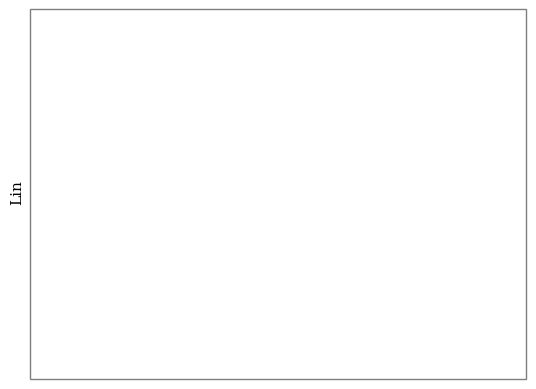

<ggplot: (-9223371932018459524)>

In [46]:
cbPalette = ["#DE090F","#2D09DE", "#DE090F", "#02000B", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

mast_df = mast_df.loc[(mast_df['DateTime'].dt.year == '2015')].copy()

plt = ggplot(mast_df)
plt = plt + geom_line(aes(x='DateTime', y='Lin'),size=1.5)
#plt = plt + geom_line(aes(x='DateTime', y='Lout'),size=1.5)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=1,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
#plt = plt + coord_cartesian(ylim=(-0.1, 0.9))
#plt = plt + scale_y_continuous(breaks=np.arange(-0.1, 1, 0.1))
#plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')


plt

## Loading Yatir data

In [34]:
yatir_df = load_tower(input_path + 'Yatir_2000-2020.csv')
yatir_df = yatir_df.loc[(yatir_df['DateTime'].dt.year >= 2015)].copy()
yatir_df = yatir_df.loc[(yatir_df['DateTime'].dt.month == 7)].copy()
yatir_df['DateTime'] = yatir_df['DateTime'] - pd.Timedelta(minutes=15)

# Rename
yatir_df.rename(columns={'S_top_atm(CM21_IV)_Wm-2': 'Sin'}, inplace=True)
yatir_df.rename(columns={'S_top_eco(CM21_III)_Wm-2': 'Sout'}, inplace=True)
yatir_df.rename(columns={'PAR_top_atm(IV)_umol_m-2s-1': 'PARin'}, inplace=True)
yatir_df.rename(columns={'PAR_top_eco(III)_umol_m-2s-1': 'PARout'}, inplace=True)
yatir_df.rename(columns={'L_top_atm(PIR_IV)_Wm-2': 'Lin'}, inplace=True)
yatir_df.rename(columns={'L_top_eco(PIR_III)_Wm-2': 'Lout'}, inplace=True)
yatir_df.rename(columns={'Fc_Cor_umol_m-2s-1': 'NEE'}, inplace=True)
yatir_df.rename(columns={'LE_Wm-2_Avg': 'LE'}, inplace=True)
yatir_df.rename(columns={'H_Wm-2': 'H'}, inplace=True)
yatir_df.rename(columns={'H2O_Con_mmol_mol-1': 'H2O'}, inplace=True)
yatir_df.rename(columns={'AirPress_Pa': 'Pa'}, inplace=True)
# yatir_df.rename(columns={'date_mid_hour': 'DateTime'}, inplace=True)

# yatir_df['DateTime'] = pd.to_datetime(yatir_df['DateTime'], format='%Y-%m-%d %H:%M:%S', utc=True)

# Convert columns to float
yatir_df['Sin']  = pd.to_numeric(yatir_df['Sin'], downcast="float")
yatir_df['Sout']  = pd.to_numeric(yatir_df['Sout'], downcast="float")
yatir_df['PARin']  = pd.to_numeric(yatir_df['PARin'], downcast="float")
yatir_df['PARout']  = pd.to_numeric(yatir_df['PARout'], downcast="float")
yatir_df['Lin']  = pd.to_numeric(yatir_df['Lin'], downcast="float")
yatir_df['Lout']  = pd.to_numeric(yatir_df['Lout'], downcast="float")
yatir_df['NEE']  = pd.to_numeric(yatir_df['NEE'], downcast="float")
yatir_df['LE']  = pd.to_numeric(yatir_df['LE'], downcast="float")
yatir_df['H']  = pd.to_numeric(yatir_df['H'], downcast="float")
yatir_df['H2O']  = pd.to_numeric(yatir_df['H2O'], downcast="float")
yatir_df['Pa']  = pd.to_numeric(yatir_df['Pa'], downcast="float")
    
yatir_df['albedo'] = yatir_df['Sout']/yatir_df['Sin']
yatir_df['Rn'] = yatir_df['Sin'] - yatir_df['Sout'] + yatir_df['Lin'] - yatir_df['Lout']


# Make air temperature mean of top of tower, according to the system used in 
def mean_tower_temp(temp, T_col_list):
    # Prepare data
    temp = temp[['DateTime'] + T_col_list].copy() # timestamp added for debugging only
    # Calculate the mean
    temp['T_mean'] = temp[T_col_list].mean(axis=1)
    # Check each column to see if the difference from the mean is > 2°C. If so, remove
    for column in T_col_list:
        temp.loc[np.abs(temp[column] - temp['T_mean']) > 2, column] = np.nan
    # Re-calculate the mean from the remaining data
    temp['T_mean'] = temp[T_col_list].mean(axis=1)
        
    return(temp['T_mean'])

# Make the mean air temperature,
# remove any value where one of them is more than 2°C off from the mean,
# and then calculate the mean again from the remaining data
yatir_df['Ta'] = mean_tower_temp(yatir_df, ['T 15m Vaisala_C', 'Prof_Tc_13m_C', 'Prof_Tc_15m_C', 'T_PIR_III_K'])

# Calculating temperature from lout
# Constants
sigma = 5.670374419*10**(-8) # Stefan-Boltzmann constant
emissivity_forest = 0.873  # Thakur 2021

yatir_df['Ts'] = ((yatir_df['Lout']/(emissivity_forest*sigma))**0.25) - 273.15

yatir_df['D_T'] = yatir_df['Ts'] - yatir_df['Ta']

yatir_df['Season'] = 'Summer'
yatir_df['Ecosystem'] = 'Yatir'

# Keep only relevant columns
yatir_df = yatir_df[['DateTime','Season','Ecosystem','Lin','Lout']]

display(yatir_df)
print('Done...')

EC Tower


C:\Users\rafas\Miniconda3\envs\analysis\lib\site-packages\IPython\core\interactiveshell.py:3337: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.


     100.0 %	 Yatir_2000-2020.csv


,DateTime,Season,Ecosystem,Lin,Lout
265872,2015-07-01 00:00:00+00:00,Summer,Yatir,308.399994,NaN
265873,2015-07-01 00:30:00+00:00,Summer,Yatir,308.200012,NaN
265874,2015-07-01 01:00:00+00:00,Summer,Yatir,307.399994,NaN
265875,2015-07-01 01:30:00+00:00,Summer,Yatir,307.500000,NaN
265876,2015-07-01 02:00:00+00:00,Summer,Yatir,307.299988,NaN
...,...,...,...,...,...
355051,2020-07-31 21:30:00+00:00,Summer,Yatir,344.500000,440.899994
355052,2020-07-31 22:00:00+00:00,Summer,Yatir,341.700012,438.299988
355053,2020-07-31 22:30:00+00:00,Summer,Yatir,341.100006,436.799988
355054,2020-07-31 23:00:00+00:00,Summer,Yatir,341.000000,436.500000


Done...


## Merge Yatir & Ktura

In [26]:
#final_df = pd.concat([mast_df, yatir_df])
final_df = mast_df.merge(yatir_df, on=['DateTime','Season','Ecosystem'])

display(final_df)

,DateTime,Season,Ecosystem,Lin_x,Lout_x,Lin_y,Lout_y


In [14]:
mean_df = averaging(final_df)
#display(mean_df)

# Create a text of summarised values (mean + stddev)
mean_df['Rn'] = mean_df['Rn_mean'].astype(float).round(0).astype(int).astype(str) + ' (' + mean_df['Rn_sd'].astype(float).round(0).astype(int).astype(str) + ')'
mean_df['H'] = mean_df['H_mean'].astype(float).round(0).astype(int).astype(str) + ' (' + mean_df['H_sd'].astype(float).round(0).astype(int).astype(str) + ')'
mean_df['LE'] = mean_df['LE_mean'].astype(float).round(0).astype(int).astype(str) + ' (' + mean_df['LE_sd'].astype(float).round(0).astype(int).astype(str) + ')'
mean_df['Ta'] = mean_df['Ta_mean'].astype(float).round(1).astype(str) + ' (' + mean_df['Ta_sd'].round(1).astype(str) + ')'
mean_df['Ts'] = mean_df['Ts_mean'].astype(float).round(1).astype(str) + ' (' + mean_df['Ts_sd'].round(1).astype(str) + ')'
mean_df['D_T'] = mean_df['D_T_mean'].astype(float).round(1).astype(str) + ' (' + mean_df['D_T_sd'].round(1).astype(str) + ')'
mean_df['rH'] = mean_df['rH_mean'].astype(float).round(0).astype(int).astype(str) + ' (' + mean_df['rH_sd'].astype(float).round(0).astype(int).astype(str) + ')'
#mean_df['Pa'] = mean_df['Pa_mean'].astype(float).round(0).astype(int).astype(str) + ' (' + mean_df['Pa_sd'].astype(float).round(0).astype(int).astype(str) + ')'
#mean_df['H2O'] = mean_df['H2O_mean'].astype(float).round(0).astype(int).astype(str) + ' (' + mean_df['H2O_sd'].astype(float).round(0).astype(int).astype(str) + ')'

# Remove the original values
mean_df.drop(['H_mean','H_sd','LE_mean','LE_sd','Rn_mean','Rn_sd','Ta_mean','Ta_sd','Ts_mean','Ts_sd','D_T_mean','D_T_sd','Pa_mean',\
              'Pa_sd','H2O_mean','H2O_sd','rH_mean','rH_sd'], axis=1, inplace=True)
#display(mean_df)

# Convert to long format
out_df = mean_df.pivot(index='Season', columns='Ecosystem').stack(level=[0])
out_df.reset_index(inplace=True)
out_df.drop(['Season'], axis=1, inplace=True)
out_df.rename(columns={'level_1': 'Parameter'}, inplace=True)
display(out_df)

out_df.to_latex(output_path + 'Ketura_Science_resistance_new.tex', index=False)

Ecosystem,Parameter,Desert background,PV field,Yatir,Yatir desert
0,D_T,17.9 (1.1),22.2 (2.4),14.2 (0.9),20.6 (1.9)
1,H,201 (50),347 (85),531 (100),228 (50)
2,LE,31 (21),36 (23),39 (50),34 (42)
3,Rn,410 (35),535 (51),671 (84),452 (71)
4,Ta,37.2 (3.0),36.8 (3.6),31.1 (2.4),29.3 (1.9)
5,Ts,55.1 (3.6),59.4 (2.1),45.4 (2.5),49.9 (2.4)
6,rH,100 (24),73 (25),29 (6),102 (30)


## Combining Ketura and Yatir dfs

In [52]:
all_df = pd.concat([mean_df, mean_yatir_df])

display(all_df)

NameError: name 'mean_yatir_df' is not defined

## Calculating resistance

In [ ]:
# Heat capacity of air [J kg-1 K-1]
all_df['cp'] = calculate_cp_moist_air(all_df['Ta'], all_df['WATER'], all_df['Pa'])

# Density of air [kg m-3]
all_df['rho'] = calculate_rho_moist_air(all_df['Ta'], all_df['WATER'], all_df['Pa']) 

# Calculate resistance [s m-1]
all_df['rH'] = all_df['rho'] * all_df['cp'] * all_df['D_T'] / all_df['H']

# t-tests seasonal means

In [ ]:
p_df = ttest_all2(all_df.loc[~all_df['Season'].isna()], ['Season', 'Ecosystem'], ['Sin','Sout','Lin','Lout','PARin','PARout'])
display(p_df)

In [ ]:
# Prepare table
final_df = mean_df.pivot(index='Season', columns='Ecosystem').stack(level=[0])
display(final_df)

final_df = final_df.reset_index()
#final_df['P'] = ''
final_df.rename(columns={'level_1': 'Parameter'}, inplace=True)


p_df = ttest_all(all_df, 'Season', ['Sin','Sout','Lin','Lout','PARin','PARout'], 'Ecosystem')

final_df = final_df.merge(p_df, on = ['Parameter', 'Season'], how='left').copy()

display(final_df)
final_df.to_latex(output_path + 'Ketura_radiative_fluxes_new.tex', index=False)

# t-tests diurnal each half-hour

In [ ]:
all_df['Time'] = all_df['DateTime'].dt.strftime('%H:%M')

# Make mean and std dev
df_means = all_df.groupby(['Ecosystem','Season','Time']).mean().reset_index()
df_sds   = all_df.groupby(['Ecosystem','Season','Time']).std().reset_index()
# rename columns
df_means.rename(columns={'Lout': 'Lout_mean'}, inplace=True)
df_means.rename(columns={'Lin': 'Lin_mean'}, inplace=True)
df_means.rename(columns={'Sout': 'Sout_mean'}, inplace=True)
df_means.rename(columns={'Sin': 'Sin_mean'}, inplace=True)
df_means.rename(columns={'PARout': 'PARout_mean'}, inplace=True)
df_means.rename(columns={'PARin': 'PARin_mean'}, inplace=True)
    
df_sds.rename(columns={'Lout': 'Lout_sd'}, inplace=True)
df_sds.rename(columns={'Lin': 'Lin_sd'}, inplace=True)
df_sds.rename(columns={'Sout': 'Sout_sd'}, inplace=True)
df_sds.rename(columns={'Sin': 'Sin_sd'}, inplace=True)
df_sds.rename(columns={'PARout': 'PARout_sd'}, inplace=True)
df_sds.rename(columns={'PARin': 'PARin_sd'}, inplace=True)


all_df_diurnal = df_means.merge(df_sds, on=['Ecosystem','Season','Time'])
all_df_diurnal['Season'] = pd.Categorical(all_df_diurnal['Season'], ordered=True, categories=['Spring','Summer','Autumn'])
# Remove the original values
all_df_diurnal.drop(['PARout_albedo_derived_x','Lout_from_drone_x','Sout_albedo_derived_x','PARout_albedo_derived_y','Lout_from_drone_y','Sout_albedo_derived_y'], axis=1, inplace=True)

display (all_df_diurnal)

## Lout night values

In [ ]:
# t-test

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Autumn, night: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Spring, night: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Summer, night: P =', pvalue_text(t[1]))

## Lin night values

In [ ]:
a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lin_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lin_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Autumn, night: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lin_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lin_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Spring, night: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lin_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '20:00') | (all_df_diurnal['Time'] < '06:00')),'Lin_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Summer, night: P =', pvalue_text(t[1]))

## Lout mid-day values

In [ ]:
a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
#t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Autumn, mid-day: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Spring, mid-day: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lout_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
#t = stats.ttest_ind(a, b, equal_var=False, nan_policy='omit') # Welch t-test for inequal variances
print('Summer, mid-day: P =', pvalue_text(t[1]))

display(all_df_diurnal)

## $L_{in}$ day values

In [ ]:
a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lin_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Autumn') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lin_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Autumn, night: P =', pvalue_text(t[1]))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lin_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Spring') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lin_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Spring, night: P =', np.round(t[1],2))

a = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'Desert background') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lin_mean']
b = all_df_diurnal.loc[(all_df_diurnal['Ecosystem'] == 'PV field') & (all_df_diurnal['Season'] == 'Summer') & ((all_df_diurnal['Time'] >= '10:00') & (all_df_diurnal['Time'] < '15:00')),'Lin_mean']
t = stats.ttest_rel(a, b, nan_policy='omit')
print('Summer, night: P =', pvalue_text(t[1]))

# Graphs

# Lout

In [ ]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='Lout_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Lout_mean - Lout_sd', ymax='Lout_mean + Lout_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$L_{out}\; (W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'lout_diurnal.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'lout_diurnal.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

# Lin

In [ ]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='Lin_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Lin_mean - Lin_sd', ymax='Lin_mean + Lin_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$L_{in}\; (W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'lin_diurnal.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'lin_diurnal.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

# Sin

In [ ]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='Sin_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Sin_mean - Sin_sd', ymax='Sin_mean + Sin_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$S_{in}\; (W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'Sin_diurnal.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'Sin_diurnal.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

# Sout

In [ ]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='Sout_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='Sout_mean - Sout_sd', ymax='Sout_mean + Sout_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$S_{out}\; (W \; m^{-2}$)', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'Sout_diurnal.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'Sout_diurnal.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

# PARin

In [ ]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='PARin_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='PARin_mean - Sin_sd', ymax='PARin_mean + PARin_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$PAR_{in}\; (\mu mol \; m^{-2} \; s^{-1}$)', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'PARin_diurnal.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'PARin_diurnal.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

# PARout

In [ ]:
cbPalette = ["#02000B", "#2D09DE", "#DE090F", "#80ff80", "#c2c2d6", "#F0E442", "#0072B2", "#D55E00", "#CC79A7"]

# Convert the times back to a “fake” timestamp:
all_df_diurnal['timestamp2'] = pd.to_datetime(all_df_diurnal['Time'], utc=True)

plt = ggplot(all_df_diurnal)
plt = plt + geom_line(aes(x='timestamp2', y='PARout_mean',linetype='Ecosystem'))
plt = plt + geom_ribbon(aes(x='timestamp2', ymin='PARout_mean - PARout_sd', ymax='PARout_mean + PARout_sd', linetype='Ecosystem'), alpha=0.1)
plt = plt + labs(x='Hour', y='$PAR_{out}\; (\mu mol \; m^{-2} \; s^{-1}$)', parse=True)
plt = plt + facet_wrap(['Season'])
#plt = plt + scale_colour_manual(values=cbPalette) + scale_fill_manual(values=cbPalette)
plt = plt + theme_bw()
plt = plt + theme(axis_text_x=element_text(size=9,rotation=30,hjust=0.5,weight='bold'),
                  axis_title_x = element_blank(),
                  axis_text_y=element_text(size=9,weight='bold'),
                  strip_text=element_text(size=9,weight='bold'),
                  legend_title=element_blank(),
                  text=element_text(family="serif"), axis_ticks_direction_y='in', axis_ticks_direction_x='in')
plt = plt + theme(legend_position = 'top')
plt = plt + scale_x_datetime(date_breaks = '6 hours', date_labels = '%H:%M')

plt.save(graphs_path + 'PARout_diurnal.pdf', width=19, height=7, units='cm', scale=1.3, dpi=600)
plt.save(graphs_path + 'PARout_diurnal.png', width=19, height=7, units='cm', scale=1.3, dpi=600)


plt

In [ ]:
diurnal_Lout_desert_march2018_df = diurnal(all_df, 'Desert', 'March')
diurnal_Lout_desert_march2018_df.to_csv(output_path + 'diurnal_Lout_desert_march2018.csv')

diurnal_Lout_pv_march2018_df = diurnal(all_df, 'Solar', 'March')
diurnal_Lout_pv_march2018_df.to_csv(output_path + 'diurnal_Lout_pv_march2018.csv')

diurnal_Lout_desert_october2018_df = diurnal(all_df, 'Desert', 'October')
diurnal_Lout_desert_october2018_df.to_csv(output_path + 'diurnal_Lout_desert_october2018.csv')

diurnal_Lout_desert_july2019_df = diurnal(all_df, 'Desert', 'July')
diurnal_Lout_desert_july2019_df.to_csv(output_path + 'diurnal_Lout_desert_july2019.csv') 

diurnal_Lout_pv_october2018_df = diurnal(all_df, 'Solar', 10)
diurnal_Lout_pv_october2018_df.to_csv(output_path + 'diurnal_Lout_pv_october2018.csv')

diurnal_Lout_pv_july2019_df = diurnal(all_df, 'Solar', 7)
diurnal_Lout_pv_july2019_df.to_csv(output_path + 'diurnal_Lout_pv_july2019.csv') 